In [1]:
import numpy as np 
import pandas as pd 

In [2]:
sensor_data = 'Plant_1_Weather_Sensor_Data.csv'
gen_data = 'Plant_1_Generation_Data.csv'

sensor_df = pd.read_csv(sensor_data)
gen_df = pd.read_csv(gen_data)

sensor_df = sensor_df.drop(['PLANT_ID','SOURCE_KEY'],axis='columns')
gen_df = gen_df.drop(['PLANT_ID'], axis='columns')
gen_df["DATE_TIME"] = pd.to_datetime(gen_df["DATE_TIME"])
sensor_df["DATE_TIME"] = pd.to_datetime(sensor_df["DATE_TIME"])
df = pd.merge(sensor_df,gen_df,on="DATE_TIME",how="inner")
df.head()

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15,25.184316,22.857507,0.0,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,2020-05-15,25.184316,22.857507,0.0,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,2020-05-15,25.184316,22.857507,0.0,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,2020-05-15,25.184316,22.857507,0.0,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,2020-05-15,25.184316,22.857507,0.0,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [3]:
x_train = df.groupby(['DATE_TIME']).sum().iloc[:-1,-2:-1]
for feature_name in x_train.columns:
    x_train[feature_name] = (x_train[feature_name] - x_train[feature_name].min())/(x_train[feature_name].max()-x_train[feature_name].min())
y_train = df.groupby(['DATE_TIME']).sum().iloc[1:,-2:-1]
for feature_name in y_train.columns:
    y_train[feature_name] = (y_train[feature_name] - y_train[feature_name].min())/(y_train[feature_name].max()-y_train[feature_name].min())

In [4]:
x_train.iloc[:277,:]

,DAILY_YIELD
DATE_TIME,
2020-05-15 00:00:00,0.000000
2020-05-15 00:15:00,0.000000
2020-05-15 00:30:00,0.000000
2020-05-15 00:45:00,0.000000
2020-05-15 01:00:00,0.000000
...,...
2020-05-17 22:45:00,0.852072
2020-05-17 23:00:00,0.852072
2020-05-17 23:15:00,0.852072


In [5]:
y_train.iloc[24:30,:]

,DAILY_YIELD
DATE_TIME,
2020-05-15 06:15:00,0.000316
2020-05-15 06:30:00,0.001675
2020-05-15 06:45:00,0.004229
2020-05-15 07:00:00,0.008865
2020-05-15 07:15:00,0.014202
2020-05-15 07:30:00,0.019871


In [6]:
x_train = x_train.values
y_train = y_train.values

In [7]:
import torch
from sklearn.model_selection import KFold
k = 10
kf = KFold(n_splits=k)
kf_data = {"train" : [],"valid" : [], "test_list" : []}
for train_index, valid_index in kf.split(x_train):
    kf_data['train'].append(torch.utils.data.TensorDataset(torch.from_numpy(x_train[train_index]),torch.from_numpy(y_train[train_index])))
    kf_data['valid'].append(torch.utils.data.TensorDataset(torch.from_numpy(x_train[valid_index]),torch.from_numpy(y_train[valid_index])))
    kf_data['test_list'].append((x_train[valid_index],y_train[valid_index]))

In [8]:
import torch.nn as nn
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hidden_1 = 200
        hidden_2 = 200
        hidden_3 = 100
        # linear layer (1 -> hidden_1)
        self.fc1 = nn.Linear(1, hidden_1)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # linear layer (n_hidden2 -> hidden_3)
        self.fc3 = nn.Linear(hidden_2, hidden_3)
        # linear layer (n_hidden3 -> 1)
        self.fc4 = nn.Linear(hidden_3, 1)
        # dropout layer (p=0.5)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 1)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc3(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc4(x)
        return x

In [9]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf

    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        for data, target in loaders['train']:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            #clear gradient
            optimizer.zero_grad()
            ## find the loss and update the model parameters accordingly
            output = model(data.float())
            loss = torch.sqrt(criterion(output, target.float()))
            loss.backward()
            optimizer.step()
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss += loss.item()*data.size(0)

        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in loaders['valid']:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data.float())
            loss = torch.sqrt(criterion(output, target.float()))
            valid_loss += loss.item()*data.size(0)

        # calculate average losses
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_loss,
            valid_loss))

        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Valid loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model

In [10]:
batch_size = 32
for i in range(k):
    model = Net()
    if use_cuda:
        model.cuda()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
    train_loader = torch.utils.data.DataLoader(kf_data['train'][i], batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(kf_data['valid'][i], batch_size=batch_size, shuffle=True)
    loaders = {'train' : train_loader, 'valid' : valid_loader}
    print()
    print(f'Fold {i + 1}')
    model = train(500, loaders, model, optimizer,criterion, use_cuda, 'model_fold_'+str(i+1)+'.pth')


Fold 1
Epoch: 1 	Training Loss: 0.482446 	Validation Loss: 0.386322
Valid loss decreased (inf --> 0.386322). Saving model ...
Epoch: 2 	Training Loss: 0.481620 	Validation Loss: 0.381173
Valid loss decreased (0.386322 --> 0.381173). Saving model ...
Epoch: 3 	Training Loss: 0.483974 	Validation Loss: 0.377753
Valid loss decreased (0.381173 --> 0.377753). Saving model ...
Epoch: 4 	Training Loss: 0.473977 	Validation Loss: 0.373402
Valid loss decreased (0.377753 --> 0.373402). Saving model ...
Epoch: 5 	Training Loss: 0.467177 	Validation Loss: 0.368354
Valid loss decreased (0.373402 --> 0.368354). Saving model ...
Epoch: 6 	Training Loss: 0.468160 	Validation Loss: 0.365718
Valid loss decreased (0.368354 --> 0.365718). Saving model ...
Epoch: 7 	Training Loss: 0.464541 	Validation Loss: 0.360764
Valid loss decreased (0.365718 --> 0.360764). Saving model ...
Epoch: 8 	Training Loss: 0.459610 	Validation Loss: 0.356070
Valid loss decreased (0.360764 --> 0.356070). Saving model ...
Epoch

Epoch: 67 	Training Loss: 0.306274 	Validation Loss: 0.230890
Valid loss decreased (0.231970 --> 0.230890). Saving model ...
Epoch: 68 	Training Loss: 0.315438 	Validation Loss: 0.229406
Valid loss decreased (0.230890 --> 0.229406). Saving model ...
Epoch: 69 	Training Loss: 0.310228 	Validation Loss: 0.228987
Valid loss decreased (0.229406 --> 0.228987). Saving model ...
Epoch: 70 	Training Loss: 0.307940 	Validation Loss: 0.228244
Valid loss decreased (0.228987 --> 0.228244). Saving model ...
Epoch: 71 	Training Loss: 0.309099 	Validation Loss: 0.227217
Valid loss decreased (0.228244 --> 0.227217). Saving model ...
Epoch: 72 	Training Loss: 0.309678 	Validation Loss: 0.226224
Valid loss decreased (0.227217 --> 0.226224). Saving model ...
Epoch: 73 	Training Loss: 0.312409 	Validation Loss: 0.225153
Valid loss decreased (0.226224 --> 0.225153). Saving model ...
Epoch: 74 	Training Loss: 0.302884 	Validation Loss: 0.223982
Valid loss decreased (0.225153 --> 0.223982). Saving model ...


Epoch: 133 	Training Loss: 0.275492 	Validation Loss: 0.172630
Valid loss decreased (0.173493 --> 0.172630). Saving model ...
Epoch: 134 	Training Loss: 0.265611 	Validation Loss: 0.172021
Valid loss decreased (0.172630 --> 0.172021). Saving model ...
Epoch: 135 	Training Loss: 0.266233 	Validation Loss: 0.171175
Valid loss decreased (0.172021 --> 0.171175). Saving model ...
Epoch: 136 	Training Loss: 0.255388 	Validation Loss: 0.170180
Valid loss decreased (0.171175 --> 0.170180). Saving model ...
Epoch: 137 	Training Loss: 0.265570 	Validation Loss: 0.169426
Valid loss decreased (0.170180 --> 0.169426). Saving model ...
Epoch: 138 	Training Loss: 0.261562 	Validation Loss: 0.168511
Valid loss decreased (0.169426 --> 0.168511). Saving model ...
Epoch: 139 	Training Loss: 0.259102 	Validation Loss: 0.167420
Valid loss decreased (0.168511 --> 0.167420). Saving model ...
Epoch: 140 	Training Loss: 0.257793 	Validation Loss: 0.167153
Valid loss decreased (0.167420 --> 0.167153). Saving mo

Epoch: 199 	Training Loss: 0.232404 	Validation Loss: 0.125959
Valid loss decreased (0.126686 --> 0.125959). Saving model ...
Epoch: 200 	Training Loss: 0.233405 	Validation Loss: 0.125433
Valid loss decreased (0.125959 --> 0.125433). Saving model ...
Epoch: 201 	Training Loss: 0.231549 	Validation Loss: 0.124429
Valid loss decreased (0.125433 --> 0.124429). Saving model ...
Epoch: 202 	Training Loss: 0.232421 	Validation Loss: 0.124231
Valid loss decreased (0.124429 --> 0.124231). Saving model ...
Epoch: 203 	Training Loss: 0.234582 	Validation Loss: 0.124090
Valid loss decreased (0.124231 --> 0.124090). Saving model ...
Epoch: 204 	Training Loss: 0.229439 	Validation Loss: 0.123517
Valid loss decreased (0.124090 --> 0.123517). Saving model ...
Epoch: 205 	Training Loss: 0.228805 	Validation Loss: 0.123005
Valid loss decreased (0.123517 --> 0.123005). Saving model ...
Epoch: 206 	Training Loss: 0.224793 	Validation Loss: 0.122727
Valid loss decreased (0.123005 --> 0.122727). Saving mo

Epoch: 284 	Training Loss: 0.206448 	Validation Loss: 0.103986
Valid loss decreased (0.104898 --> 0.103986). Saving model ...
Epoch: 285 	Training Loss: 0.205168 	Validation Loss: 0.104511
Epoch: 286 	Training Loss: 0.202872 	Validation Loss: 0.104685
Epoch: 287 	Training Loss: 0.206433 	Validation Loss: 0.105727
Epoch: 288 	Training Loss: 0.201781 	Validation Loss: 0.105360
Epoch: 289 	Training Loss: 0.206152 	Validation Loss: 0.105571
Epoch: 290 	Training Loss: 0.206351 	Validation Loss: 0.104985
Epoch: 291 	Training Loss: 0.203100 	Validation Loss: 0.105327
Epoch: 292 	Training Loss: 0.211314 	Validation Loss: 0.105650
Epoch: 293 	Training Loss: 0.202474 	Validation Loss: 0.103952
Valid loss decreased (0.103986 --> 0.103952). Saving model ...
Epoch: 294 	Training Loss: 0.202146 	Validation Loss: 0.104666
Epoch: 295 	Training Loss: 0.214004 	Validation Loss: 0.105376
Epoch: 296 	Training Loss: 0.199237 	Validation Loss: 0.105984
Epoch: 297 	Training Loss: 0.206922 	Validation Loss: 0

Epoch: 413 	Training Loss: 0.190224 	Validation Loss: 0.112376
Epoch: 414 	Training Loss: 0.189396 	Validation Loss: 0.112825
Epoch: 415 	Training Loss: 0.192352 	Validation Loss: 0.112667
Epoch: 416 	Training Loss: 0.187196 	Validation Loss: 0.112684
Epoch: 417 	Training Loss: 0.184822 	Validation Loss: 0.112212
Epoch: 418 	Training Loss: 0.187435 	Validation Loss: 0.112105
Epoch: 419 	Training Loss: 0.186236 	Validation Loss: 0.112175
Epoch: 420 	Training Loss: 0.190234 	Validation Loss: 0.112451
Epoch: 421 	Training Loss: 0.190544 	Validation Loss: 0.112366
Epoch: 422 	Training Loss: 0.187391 	Validation Loss: 0.112248
Epoch: 423 	Training Loss: 0.189030 	Validation Loss: 0.112475
Epoch: 424 	Training Loss: 0.180834 	Validation Loss: 0.111765
Epoch: 425 	Training Loss: 0.194392 	Validation Loss: 0.112496
Epoch: 426 	Training Loss: 0.192796 	Validation Loss: 0.113073
Epoch: 427 	Training Loss: 0.190288 	Validation Loss: 0.113450
Epoch: 428 	Training Loss: 0.186693 	Validation Loss: 0

Epoch: 23 	Training Loss: 0.408023 	Validation Loss: 0.371693
Valid loss decreased (0.375409 --> 0.371693). Saving model ...
Epoch: 24 	Training Loss: 0.409925 	Validation Loss: 0.369714
Valid loss decreased (0.371693 --> 0.369714). Saving model ...
Epoch: 25 	Training Loss: 0.404226 	Validation Loss: 0.364206
Valid loss decreased (0.369714 --> 0.364206). Saving model ...
Epoch: 26 	Training Loss: 0.403327 	Validation Loss: 0.361459
Valid loss decreased (0.364206 --> 0.361459). Saving model ...
Epoch: 27 	Training Loss: 0.398002 	Validation Loss: 0.360998
Valid loss decreased (0.361459 --> 0.360998). Saving model ...
Epoch: 28 	Training Loss: 0.394299 	Validation Loss: 0.356813
Valid loss decreased (0.360998 --> 0.356813). Saving model ...
Epoch: 29 	Training Loss: 0.393356 	Validation Loss: 0.354376
Valid loss decreased (0.356813 --> 0.354376). Saving model ...
Epoch: 30 	Training Loss: 0.394655 	Validation Loss: 0.350991
Valid loss decreased (0.354376 --> 0.350991). Saving model ...


Epoch: 91 	Training Loss: 0.299469 	Validation Loss: 0.241263
Valid loss decreased (0.242203 --> 0.241263). Saving model ...
Epoch: 92 	Training Loss: 0.296864 	Validation Loss: 0.240220
Valid loss decreased (0.241263 --> 0.240220). Saving model ...
Epoch: 93 	Training Loss: 0.295821 	Validation Loss: 0.238903
Valid loss decreased (0.240220 --> 0.238903). Saving model ...
Epoch: 94 	Training Loss: 0.293216 	Validation Loss: 0.237549
Valid loss decreased (0.238903 --> 0.237549). Saving model ...
Epoch: 95 	Training Loss: 0.297655 	Validation Loss: 0.236598
Valid loss decreased (0.237549 --> 0.236598). Saving model ...
Epoch: 96 	Training Loss: 0.297023 	Validation Loss: 0.235504
Valid loss decreased (0.236598 --> 0.235504). Saving model ...
Epoch: 97 	Training Loss: 0.292135 	Validation Loss: 0.233920
Valid loss decreased (0.235504 --> 0.233920). Saving model ...
Epoch: 98 	Training Loss: 0.293252 	Validation Loss: 0.233214
Valid loss decreased (0.233920 --> 0.233214). Saving model ...


Epoch: 160 	Training Loss: 0.250557 	Validation Loss: 0.171325
Valid loss decreased (0.172512 --> 0.171325). Saving model ...
Epoch: 161 	Training Loss: 0.252982 	Validation Loss: 0.171272
Valid loss decreased (0.171325 --> 0.171272). Saving model ...
Epoch: 162 	Training Loss: 0.243366 	Validation Loss: 0.170260
Valid loss decreased (0.171272 --> 0.170260). Saving model ...
Epoch: 163 	Training Loss: 0.244103 	Validation Loss: 0.169464
Valid loss decreased (0.170260 --> 0.169464). Saving model ...
Epoch: 164 	Training Loss: 0.254696 	Validation Loss: 0.167841
Valid loss decreased (0.169464 --> 0.167841). Saving model ...
Epoch: 165 	Training Loss: 0.247067 	Validation Loss: 0.168059
Epoch: 166 	Training Loss: 0.247206 	Validation Loss: 0.166602
Valid loss decreased (0.167841 --> 0.166602). Saving model ...
Epoch: 167 	Training Loss: 0.246005 	Validation Loss: 0.166110
Valid loss decreased (0.166602 --> 0.166110). Saving model ...
Epoch: 168 	Training Loss: 0.241848 	Validation Loss: 0

Epoch: 238 	Training Loss: 0.215148 	Validation Loss: 0.129024
Epoch: 239 	Training Loss: 0.211055 	Validation Loss: 0.127635
Valid loss decreased (0.128291 --> 0.127635). Saving model ...
Epoch: 240 	Training Loss: 0.213312 	Validation Loss: 0.127738
Epoch: 241 	Training Loss: 0.211890 	Validation Loss: 0.128326
Epoch: 242 	Training Loss: 0.208650 	Validation Loss: 0.127659
Epoch: 243 	Training Loss: 0.213364 	Validation Loss: 0.128006
Epoch: 244 	Training Loss: 0.211387 	Validation Loss: 0.126936
Valid loss decreased (0.127635 --> 0.126936). Saving model ...
Epoch: 245 	Training Loss: 0.208026 	Validation Loss: 0.126751
Valid loss decreased (0.126936 --> 0.126751). Saving model ...
Epoch: 246 	Training Loss: 0.209086 	Validation Loss: 0.125440
Valid loss decreased (0.126751 --> 0.125440). Saving model ...
Epoch: 247 	Training Loss: 0.207284 	Validation Loss: 0.126653
Epoch: 248 	Training Loss: 0.214885 	Validation Loss: 0.126669
Epoch: 249 	Training Loss: 0.212388 	Validation Loss: 0

Epoch: 360 	Training Loss: 0.195152 	Validation Loss: 0.127761
Epoch: 361 	Training Loss: 0.191108 	Validation Loss: 0.128315
Epoch: 362 	Training Loss: 0.192508 	Validation Loss: 0.128446
Epoch: 363 	Training Loss: 0.190445 	Validation Loss: 0.127199
Epoch: 364 	Training Loss: 0.188515 	Validation Loss: 0.127800
Epoch: 365 	Training Loss: 0.191751 	Validation Loss: 0.127713
Epoch: 366 	Training Loss: 0.188499 	Validation Loss: 0.128129
Epoch: 367 	Training Loss: 0.193093 	Validation Loss: 0.127469
Epoch: 368 	Training Loss: 0.185704 	Validation Loss: 0.126868
Epoch: 369 	Training Loss: 0.191593 	Validation Loss: 0.127026
Epoch: 370 	Training Loss: 0.196984 	Validation Loss: 0.127867
Epoch: 371 	Training Loss: 0.195790 	Validation Loss: 0.126922
Epoch: 372 	Training Loss: 0.194184 	Validation Loss: 0.126089
Epoch: 373 	Training Loss: 0.191175 	Validation Loss: 0.127291
Epoch: 374 	Training Loss: 0.187058 	Validation Loss: 0.126916
Epoch: 375 	Training Loss: 0.188243 	Validation Loss: 0

Epoch: 491 	Training Loss: 0.181009 	Validation Loss: 0.135273
Epoch: 492 	Training Loss: 0.174218 	Validation Loss: 0.135312
Epoch: 493 	Training Loss: 0.179683 	Validation Loss: 0.135953
Epoch: 494 	Training Loss: 0.176185 	Validation Loss: 0.135465
Epoch: 495 	Training Loss: 0.175833 	Validation Loss: 0.136311
Epoch: 496 	Training Loss: 0.178909 	Validation Loss: 0.136673
Epoch: 497 	Training Loss: 0.175300 	Validation Loss: 0.136070
Epoch: 498 	Training Loss: 0.175679 	Validation Loss: 0.136673
Epoch: 499 	Training Loss: 0.178963 	Validation Loss: 0.136947
Epoch: 500 	Training Loss: 0.180550 	Validation Loss: 0.137262

Fold 3
Epoch: 1 	Training Loss: 0.490803 	Validation Loss: 0.512850
Valid loss decreased (inf --> 0.512850). Saving model ...
Epoch: 2 	Training Loss: 0.484655 	Validation Loss: 0.506867
Valid loss decreased (0.512850 --> 0.506867). Saving model ...
Epoch: 3 	Training Loss: 0.478209 	Validation Loss: 0.502693
Valid loss decreased (0.506867 --> 0.502693). Saving model

Epoch: 64 	Training Loss: 0.325877 	Validation Loss: 0.310855
Valid loss decreased (0.311937 --> 0.310855). Saving model ...
Epoch: 65 	Training Loss: 0.323586 	Validation Loss: 0.308883
Valid loss decreased (0.310855 --> 0.308883). Saving model ...
Epoch: 66 	Training Loss: 0.322964 	Validation Loss: 0.307645
Valid loss decreased (0.308883 --> 0.307645). Saving model ...
Epoch: 67 	Training Loss: 0.322315 	Validation Loss: 0.305532
Valid loss decreased (0.307645 --> 0.305532). Saving model ...
Epoch: 68 	Training Loss: 0.320310 	Validation Loss: 0.304703
Valid loss decreased (0.305532 --> 0.304703). Saving model ...
Epoch: 69 	Training Loss: 0.316674 	Validation Loss: 0.302824
Valid loss decreased (0.304703 --> 0.302824). Saving model ...
Epoch: 70 	Training Loss: 0.324074 	Validation Loss: 0.301946
Valid loss decreased (0.302824 --> 0.301946). Saving model ...
Epoch: 71 	Training Loss: 0.323437 	Validation Loss: 0.299565
Valid loss decreased (0.301946 --> 0.299565). Saving model ...


Epoch: 131 	Training Loss: 0.279560 	Validation Loss: 0.242556
Valid loss decreased (0.243828 --> 0.242556). Saving model ...
Epoch: 132 	Training Loss: 0.281593 	Validation Loss: 0.242319
Valid loss decreased (0.242556 --> 0.242319). Saving model ...
Epoch: 133 	Training Loss: 0.277868 	Validation Loss: 0.240249
Valid loss decreased (0.242319 --> 0.240249). Saving model ...
Epoch: 134 	Training Loss: 0.275417 	Validation Loss: 0.239911
Valid loss decreased (0.240249 --> 0.239911). Saving model ...
Epoch: 135 	Training Loss: 0.276351 	Validation Loss: 0.239167
Valid loss decreased (0.239911 --> 0.239167). Saving model ...
Epoch: 136 	Training Loss: 0.269208 	Validation Loss: 0.238776
Valid loss decreased (0.239167 --> 0.238776). Saving model ...
Epoch: 137 	Training Loss: 0.271620 	Validation Loss: 0.237103
Valid loss decreased (0.238776 --> 0.237103). Saving model ...
Epoch: 138 	Training Loss: 0.278016 	Validation Loss: 0.236920
Valid loss decreased (0.237103 --> 0.236920). Saving mo

Epoch: 205 	Training Loss: 0.237865 	Validation Loss: 0.185953
Valid loss decreased (0.186547 --> 0.185953). Saving model ...
Epoch: 206 	Training Loss: 0.240181 	Validation Loss: 0.185164
Valid loss decreased (0.185953 --> 0.185164). Saving model ...
Epoch: 207 	Training Loss: 0.236639 	Validation Loss: 0.182571
Valid loss decreased (0.185164 --> 0.182571). Saving model ...
Epoch: 208 	Training Loss: 0.239831 	Validation Loss: 0.183596
Epoch: 209 	Training Loss: 0.242041 	Validation Loss: 0.182877
Epoch: 210 	Training Loss: 0.233218 	Validation Loss: 0.183133
Epoch: 211 	Training Loss: 0.231606 	Validation Loss: 0.181268
Valid loss decreased (0.182571 --> 0.181268). Saving model ...
Epoch: 212 	Training Loss: 0.231927 	Validation Loss: 0.181682
Epoch: 213 	Training Loss: 0.229945 	Validation Loss: 0.181345
Epoch: 214 	Training Loss: 0.233299 	Validation Loss: 0.180444
Valid loss decreased (0.181268 --> 0.180444). Saving model ...
Epoch: 215 	Training Loss: 0.236034 	Validation Loss: 0

Epoch: 295 	Training Loss: 0.213321 	Validation Loss: 0.142035
Valid loss decreased (0.143087 --> 0.142035). Saving model ...
Epoch: 296 	Training Loss: 0.209505 	Validation Loss: 0.142782
Epoch: 297 	Training Loss: 0.198756 	Validation Loss: 0.142036
Epoch: 298 	Training Loss: 0.200203 	Validation Loss: 0.144232
Epoch: 299 	Training Loss: 0.203828 	Validation Loss: 0.144145
Epoch: 300 	Training Loss: 0.210819 	Validation Loss: 0.142595
Epoch: 301 	Training Loss: 0.209109 	Validation Loss: 0.141916
Valid loss decreased (0.142035 --> 0.141916). Saving model ...
Epoch: 302 	Training Loss: 0.203958 	Validation Loss: 0.142476
Epoch: 303 	Training Loss: 0.207228 	Validation Loss: 0.142353
Epoch: 304 	Training Loss: 0.206859 	Validation Loss: 0.143003
Epoch: 305 	Training Loss: 0.210514 	Validation Loss: 0.141268
Valid loss decreased (0.141916 --> 0.141268). Saving model ...
Epoch: 306 	Training Loss: 0.203269 	Validation Loss: 0.143165
Epoch: 307 	Training Loss: 0.194380 	Validation Loss: 0

Epoch: 413 	Training Loss: 0.191273 	Validation Loss: 0.140322
Epoch: 414 	Training Loss: 0.182170 	Validation Loss: 0.140881
Epoch: 415 	Training Loss: 0.191391 	Validation Loss: 0.141392
Epoch: 416 	Training Loss: 0.193787 	Validation Loss: 0.140556
Epoch: 417 	Training Loss: 0.188387 	Validation Loss: 0.139689
Epoch: 418 	Training Loss: 0.188573 	Validation Loss: 0.140278
Epoch: 419 	Training Loss: 0.191337 	Validation Loss: 0.139063
Epoch: 420 	Training Loss: 0.180758 	Validation Loss: 0.139618
Epoch: 421 	Training Loss: 0.186567 	Validation Loss: 0.140172
Epoch: 422 	Training Loss: 0.183717 	Validation Loss: 0.140004
Epoch: 423 	Training Loss: 0.194982 	Validation Loss: 0.138046
Epoch: 424 	Training Loss: 0.186944 	Validation Loss: 0.138205
Epoch: 425 	Training Loss: 0.185491 	Validation Loss: 0.137872
Epoch: 426 	Training Loss: 0.191438 	Validation Loss: 0.138805
Epoch: 427 	Training Loss: 0.187382 	Validation Loss: 0.138440
Epoch: 428 	Training Loss: 0.186204 	Validation Loss: 0

Epoch: 24 	Training Loss: 0.507064 	Validation Loss: 0.459464
Valid loss decreased (0.464620 --> 0.459464). Saving model ...
Epoch: 25 	Training Loss: 0.503786 	Validation Loss: 0.460606
Epoch: 26 	Training Loss: 0.497613 	Validation Loss: 0.457475
Valid loss decreased (0.459464 --> 0.457475). Saving model ...
Epoch: 27 	Training Loss: 0.493702 	Validation Loss: 0.453915
Valid loss decreased (0.457475 --> 0.453915). Saving model ...
Epoch: 28 	Training Loss: 0.491628 	Validation Loss: 0.450195
Valid loss decreased (0.453915 --> 0.450195). Saving model ...
Epoch: 29 	Training Loss: 0.486121 	Validation Loss: 0.447833
Valid loss decreased (0.450195 --> 0.447833). Saving model ...
Epoch: 30 	Training Loss: 0.481999 	Validation Loss: 0.444611
Valid loss decreased (0.447833 --> 0.444611). Saving model ...
Epoch: 31 	Training Loss: 0.477714 	Validation Loss: 0.440124
Valid loss decreased (0.444611 --> 0.440124). Saving model ...
Epoch: 32 	Training Loss: 0.477671 	Validation Loss: 0.439899
V

Epoch: 96 	Training Loss: 0.329898 	Validation Loss: 0.305303
Valid loss decreased (0.305790 --> 0.305303). Saving model ...
Epoch: 97 	Training Loss: 0.323556 	Validation Loss: 0.302755
Valid loss decreased (0.305303 --> 0.302755). Saving model ...
Epoch: 98 	Training Loss: 0.326168 	Validation Loss: 0.300708
Valid loss decreased (0.302755 --> 0.300708). Saving model ...
Epoch: 99 	Training Loss: 0.320215 	Validation Loss: 0.298806
Valid loss decreased (0.300708 --> 0.298806). Saving model ...
Epoch: 100 	Training Loss: 0.325182 	Validation Loss: 0.298931
Epoch: 101 	Training Loss: 0.318994 	Validation Loss: 0.298072
Valid loss decreased (0.298806 --> 0.298072). Saving model ...
Epoch: 102 	Training Loss: 0.316685 	Validation Loss: 0.296523
Valid loss decreased (0.298072 --> 0.296523). Saving model ...
Epoch: 103 	Training Loss: 0.322979 	Validation Loss: 0.294733
Valid loss decreased (0.296523 --> 0.294733). Saving model ...
Epoch: 104 	Training Loss: 0.318504 	Validation Loss: 0.291

Epoch: 164 	Training Loss: 0.271484 	Validation Loss: 0.224314
Valid loss decreased (0.225672 --> 0.224314). Saving model ...
Epoch: 165 	Training Loss: 0.268133 	Validation Loss: 0.223097
Valid loss decreased (0.224314 --> 0.223097). Saving model ...
Epoch: 166 	Training Loss: 0.266025 	Validation Loss: 0.222256
Valid loss decreased (0.223097 --> 0.222256). Saving model ...
Epoch: 167 	Training Loss: 0.271097 	Validation Loss: 0.220982
Valid loss decreased (0.222256 --> 0.220982). Saving model ...
Epoch: 168 	Training Loss: 0.265327 	Validation Loss: 0.219678
Valid loss decreased (0.220982 --> 0.219678). Saving model ...
Epoch: 169 	Training Loss: 0.260278 	Validation Loss: 0.219313
Valid loss decreased (0.219678 --> 0.219313). Saving model ...
Epoch: 170 	Training Loss: 0.264518 	Validation Loss: 0.217883
Valid loss decreased (0.219313 --> 0.217883). Saving model ...
Epoch: 171 	Training Loss: 0.269532 	Validation Loss: 0.216815
Valid loss decreased (0.217883 --> 0.216815). Saving mo

Epoch: 230 	Training Loss: 0.230629 	Validation Loss: 0.154127
Epoch: 231 	Training Loss: 0.229297 	Validation Loss: 0.152488
Valid loss decreased (0.153342 --> 0.152488). Saving model ...
Epoch: 232 	Training Loss: 0.228546 	Validation Loss: 0.151571
Valid loss decreased (0.152488 --> 0.151571). Saving model ...
Epoch: 233 	Training Loss: 0.228353 	Validation Loss: 0.150490
Valid loss decreased (0.151571 --> 0.150490). Saving model ...
Epoch: 234 	Training Loss: 0.228156 	Validation Loss: 0.150400
Valid loss decreased (0.150490 --> 0.150400). Saving model ...
Epoch: 235 	Training Loss: 0.224175 	Validation Loss: 0.149231
Valid loss decreased (0.150400 --> 0.149231). Saving model ...
Epoch: 236 	Training Loss: 0.221397 	Validation Loss: 0.148155
Valid loss decreased (0.149231 --> 0.148155). Saving model ...
Epoch: 237 	Training Loss: 0.222579 	Validation Loss: 0.147547
Valid loss decreased (0.148155 --> 0.147547). Saving model ...
Epoch: 238 	Training Loss: 0.221210 	Validation Loss: 0

Epoch: 308 	Training Loss: 0.195603 	Validation Loss: 0.103726
Epoch: 309 	Training Loss: 0.198954 	Validation Loss: 0.104058
Epoch: 310 	Training Loss: 0.198505 	Validation Loss: 0.104348
Epoch: 311 	Training Loss: 0.194160 	Validation Loss: 0.104302
Epoch: 312 	Training Loss: 0.204358 	Validation Loss: 0.102776
Valid loss decreased (0.103508 --> 0.102776). Saving model ...
Epoch: 313 	Training Loss: 0.202242 	Validation Loss: 0.102971
Epoch: 314 	Training Loss: 0.198002 	Validation Loss: 0.101562
Valid loss decreased (0.102776 --> 0.101562). Saving model ...
Epoch: 315 	Training Loss: 0.197511 	Validation Loss: 0.102689
Epoch: 316 	Training Loss: 0.199652 	Validation Loss: 0.104213
Epoch: 317 	Training Loss: 0.195488 	Validation Loss: 0.102151
Epoch: 318 	Training Loss: 0.198264 	Validation Loss: 0.102808
Epoch: 319 	Training Loss: 0.197235 	Validation Loss: 0.102152
Epoch: 320 	Training Loss: 0.195310 	Validation Loss: 0.103033
Epoch: 321 	Training Loss: 0.199394 	Validation Loss: 0

Epoch: 428 	Training Loss: 0.176400 	Validation Loss: 0.099987
Epoch: 429 	Training Loss: 0.188452 	Validation Loss: 0.101561
Epoch: 430 	Training Loss: 0.185479 	Validation Loss: 0.099811
Epoch: 431 	Training Loss: 0.179750 	Validation Loss: 0.101093
Epoch: 432 	Training Loss: 0.183425 	Validation Loss: 0.101365
Epoch: 433 	Training Loss: 0.181303 	Validation Loss: 0.100371
Epoch: 434 	Training Loss: 0.182154 	Validation Loss: 0.100151
Epoch: 435 	Training Loss: 0.181454 	Validation Loss: 0.101769
Epoch: 436 	Training Loss: 0.178888 	Validation Loss: 0.101959
Epoch: 437 	Training Loss: 0.183694 	Validation Loss: 0.102049
Epoch: 438 	Training Loss: 0.182295 	Validation Loss: 0.102116
Epoch: 439 	Training Loss: 0.182776 	Validation Loss: 0.102983
Epoch: 440 	Training Loss: 0.181880 	Validation Loss: 0.103299
Epoch: 441 	Training Loss: 0.182510 	Validation Loss: 0.104477
Epoch: 442 	Training Loss: 0.181081 	Validation Loss: 0.102734
Epoch: 443 	Training Loss: 0.183310 	Validation Loss: 0

Epoch: 30 	Training Loss: 0.380859 	Validation Loss: 0.467590
Valid loss decreased (0.472542 --> 0.467590). Saving model ...
Epoch: 31 	Training Loss: 0.376703 	Validation Loss: 0.461616
Valid loss decreased (0.467590 --> 0.461616). Saving model ...
Epoch: 32 	Training Loss: 0.371593 	Validation Loss: 0.454498
Valid loss decreased (0.461616 --> 0.454498). Saving model ...
Epoch: 33 	Training Loss: 0.360943 	Validation Loss: 0.449238
Valid loss decreased (0.454498 --> 0.449238). Saving model ...
Epoch: 34 	Training Loss: 0.369858 	Validation Loss: 0.442810
Valid loss decreased (0.449238 --> 0.442810). Saving model ...
Epoch: 35 	Training Loss: 0.359011 	Validation Loss: 0.438491
Valid loss decreased (0.442810 --> 0.438491). Saving model ...
Epoch: 36 	Training Loss: 0.355979 	Validation Loss: 0.433746
Valid loss decreased (0.438491 --> 0.433746). Saving model ...
Epoch: 37 	Training Loss: 0.358075 	Validation Loss: 0.428422
Valid loss decreased (0.433746 --> 0.428422). Saving model ...


Epoch: 97 	Training Loss: 0.284502 	Validation Loss: 0.270066
Valid loss decreased (0.272717 --> 0.270066). Saving model ...
Epoch: 98 	Training Loss: 0.282214 	Validation Loss: 0.269657
Valid loss decreased (0.270066 --> 0.269657). Saving model ...
Epoch: 99 	Training Loss: 0.275512 	Validation Loss: 0.267939
Valid loss decreased (0.269657 --> 0.267939). Saving model ...
Epoch: 100 	Training Loss: 0.283922 	Validation Loss: 0.266201
Valid loss decreased (0.267939 --> 0.266201). Saving model ...
Epoch: 101 	Training Loss: 0.283384 	Validation Loss: 0.264881
Valid loss decreased (0.266201 --> 0.264881). Saving model ...
Epoch: 102 	Training Loss: 0.281280 	Validation Loss: 0.263962
Valid loss decreased (0.264881 --> 0.263962). Saving model ...
Epoch: 103 	Training Loss: 0.278974 	Validation Loss: 0.262620
Valid loss decreased (0.263962 --> 0.262620). Saving model ...
Epoch: 104 	Training Loss: 0.276936 	Validation Loss: 0.261113
Valid loss decreased (0.262620 --> 0.261113). Saving model

Epoch: 164 	Training Loss: 0.243004 	Validation Loss: 0.204090
Valid loss decreased (0.204666 --> 0.204090). Saving model ...
Epoch: 165 	Training Loss: 0.240493 	Validation Loss: 0.202355
Valid loss decreased (0.204090 --> 0.202355). Saving model ...
Epoch: 166 	Training Loss: 0.242357 	Validation Loss: 0.201854
Valid loss decreased (0.202355 --> 0.201854). Saving model ...
Epoch: 167 	Training Loss: 0.240495 	Validation Loss: 0.201315
Valid loss decreased (0.201854 --> 0.201315). Saving model ...
Epoch: 168 	Training Loss: 0.241330 	Validation Loss: 0.199855
Valid loss decreased (0.201315 --> 0.199855). Saving model ...
Epoch: 169 	Training Loss: 0.242833 	Validation Loss: 0.200130
Epoch: 170 	Training Loss: 0.237674 	Validation Loss: 0.199706
Valid loss decreased (0.199855 --> 0.199706). Saving model ...
Epoch: 171 	Training Loss: 0.236011 	Validation Loss: 0.199674
Valid loss decreased (0.199706 --> 0.199674). Saving model ...
Epoch: 172 	Training Loss: 0.239154 	Validation Loss: 0

Epoch: 249 	Training Loss: 0.209760 	Validation Loss: 0.166302
Epoch: 250 	Training Loss: 0.210712 	Validation Loss: 0.166470
Epoch: 251 	Training Loss: 0.204535 	Validation Loss: 0.164593
Valid loss decreased (0.166060 --> 0.164593). Saving model ...
Epoch: 252 	Training Loss: 0.211894 	Validation Loss: 0.165506
Epoch: 253 	Training Loss: 0.212902 	Validation Loss: 0.163419
Valid loss decreased (0.164593 --> 0.163419). Saving model ...
Epoch: 254 	Training Loss: 0.203614 	Validation Loss: 0.165465
Epoch: 255 	Training Loss: 0.204206 	Validation Loss: 0.165369
Epoch: 256 	Training Loss: 0.210183 	Validation Loss: 0.164434
Epoch: 257 	Training Loss: 0.209536 	Validation Loss: 0.165887
Epoch: 258 	Training Loss: 0.210234 	Validation Loss: 0.165314
Epoch: 259 	Training Loss: 0.210917 	Validation Loss: 0.165655
Epoch: 260 	Training Loss: 0.209012 	Validation Loss: 0.165220
Epoch: 261 	Training Loss: 0.208756 	Validation Loss: 0.165928
Epoch: 262 	Training Loss: 0.201801 	Validation Loss: 0

Epoch: 365 	Training Loss: 0.185185 	Validation Loss: 0.159687
Epoch: 366 	Training Loss: 0.189011 	Validation Loss: 0.160067
Epoch: 367 	Training Loss: 0.183825 	Validation Loss: 0.160011
Epoch: 368 	Training Loss: 0.184755 	Validation Loss: 0.159675
Epoch: 369 	Training Loss: 0.186467 	Validation Loss: 0.159188
Epoch: 370 	Training Loss: 0.184861 	Validation Loss: 0.157559
Epoch: 371 	Training Loss: 0.189185 	Validation Loss: 0.158751
Epoch: 372 	Training Loss: 0.192777 	Validation Loss: 0.158343
Epoch: 373 	Training Loss: 0.183614 	Validation Loss: 0.159419
Epoch: 374 	Training Loss: 0.183457 	Validation Loss: 0.159447
Epoch: 375 	Training Loss: 0.191836 	Validation Loss: 0.158797
Epoch: 376 	Training Loss: 0.193188 	Validation Loss: 0.159610
Epoch: 377 	Training Loss: 0.189638 	Validation Loss: 0.160587
Epoch: 378 	Training Loss: 0.186167 	Validation Loss: 0.160821
Epoch: 379 	Training Loss: 0.186582 	Validation Loss: 0.160674
Epoch: 380 	Training Loss: 0.191448 	Validation Loss: 0

Epoch: 496 	Training Loss: 0.175040 	Validation Loss: 0.167033
Epoch: 497 	Training Loss: 0.170720 	Validation Loss: 0.168781
Epoch: 498 	Training Loss: 0.173445 	Validation Loss: 0.168887
Epoch: 499 	Training Loss: 0.174990 	Validation Loss: 0.168990
Epoch: 500 	Training Loss: 0.171068 	Validation Loss: 0.168165

Fold 6
Epoch: 1 	Training Loss: 0.468843 	Validation Loss: 0.431804
Valid loss decreased (inf --> 0.431804). Saving model ...
Epoch: 2 	Training Loss: 0.465800 	Validation Loss: 0.427145
Valid loss decreased (0.431804 --> 0.427145). Saving model ...
Epoch: 3 	Training Loss: 0.455893 	Validation Loss: 0.427510
Epoch: 4 	Training Loss: 0.453592 	Validation Loss: 0.424226
Valid loss decreased (0.427145 --> 0.424226). Saving model ...
Epoch: 5 	Training Loss: 0.448384 	Validation Loss: 0.419231
Valid loss decreased (0.424226 --> 0.419231). Saving model ...
Epoch: 6 	Training Loss: 0.449099 	Validation Loss: 0.413446
Valid loss decreased (0.419231 --> 0.413446). Saving model ...
E

Epoch: 68 	Training Loss: 0.297244 	Validation Loss: 0.265145
Valid loss decreased (0.268741 --> 0.265145). Saving model ...
Epoch: 69 	Training Loss: 0.297977 	Validation Loss: 0.264359
Valid loss decreased (0.265145 --> 0.264359). Saving model ...
Epoch: 70 	Training Loss: 0.294329 	Validation Loss: 0.262604
Valid loss decreased (0.264359 --> 0.262604). Saving model ...
Epoch: 71 	Training Loss: 0.297153 	Validation Loss: 0.260690
Valid loss decreased (0.262604 --> 0.260690). Saving model ...
Epoch: 72 	Training Loss: 0.293702 	Validation Loss: 0.259847
Valid loss decreased (0.260690 --> 0.259847). Saving model ...
Epoch: 73 	Training Loss: 0.291379 	Validation Loss: 0.258618
Valid loss decreased (0.259847 --> 0.258618). Saving model ...
Epoch: 74 	Training Loss: 0.289794 	Validation Loss: 0.257314
Valid loss decreased (0.258618 --> 0.257314). Saving model ...
Epoch: 75 	Training Loss: 0.292104 	Validation Loss: 0.254756
Valid loss decreased (0.257314 --> 0.254756). Saving model ...


Epoch: 137 	Training Loss: 0.242962 	Validation Loss: 0.182360
Valid loss decreased (0.184367 --> 0.182360). Saving model ...
Epoch: 138 	Training Loss: 0.245777 	Validation Loss: 0.180698
Valid loss decreased (0.182360 --> 0.180698). Saving model ...
Epoch: 139 	Training Loss: 0.235104 	Validation Loss: 0.180658
Valid loss decreased (0.180698 --> 0.180658). Saving model ...
Epoch: 140 	Training Loss: 0.238685 	Validation Loss: 0.178296
Valid loss decreased (0.180658 --> 0.178296). Saving model ...
Epoch: 141 	Training Loss: 0.236937 	Validation Loss: 0.177865
Valid loss decreased (0.178296 --> 0.177865). Saving model ...
Epoch: 142 	Training Loss: 0.236354 	Validation Loss: 0.175537
Valid loss decreased (0.177865 --> 0.175537). Saving model ...
Epoch: 143 	Training Loss: 0.232063 	Validation Loss: 0.176958
Epoch: 144 	Training Loss: 0.236554 	Validation Loss: 0.177801
Epoch: 145 	Training Loss: 0.239189 	Validation Loss: 0.176148
Epoch: 146 	Training Loss: 0.236580 	Validation Loss: 0

Epoch: 214 	Training Loss: 0.205054 	Validation Loss: 0.133322
Epoch: 215 	Training Loss: 0.203699 	Validation Loss: 0.132947
Epoch: 216 	Training Loss: 0.201757 	Validation Loss: 0.132500
Valid loss decreased (0.132588 --> 0.132500). Saving model ...
Epoch: 217 	Training Loss: 0.204243 	Validation Loss: 0.132810
Epoch: 218 	Training Loss: 0.196968 	Validation Loss: 0.132515
Epoch: 219 	Training Loss: 0.196184 	Validation Loss: 0.131100
Valid loss decreased (0.132500 --> 0.131100). Saving model ...
Epoch: 220 	Training Loss: 0.195801 	Validation Loss: 0.129939
Valid loss decreased (0.131100 --> 0.129939). Saving model ...
Epoch: 221 	Training Loss: 0.202291 	Validation Loss: 0.131407
Epoch: 222 	Training Loss: 0.204432 	Validation Loss: 0.129296
Valid loss decreased (0.129939 --> 0.129296). Saving model ...
Epoch: 223 	Training Loss: 0.200868 	Validation Loss: 0.130204
Epoch: 224 	Training Loss: 0.195419 	Validation Loss: 0.130593
Epoch: 225 	Training Loss: 0.194685 	Validation Loss: 0

Epoch: 329 	Training Loss: 0.183409 	Validation Loss: 0.129977
Epoch: 330 	Training Loss: 0.180701 	Validation Loss: 0.129519
Epoch: 331 	Training Loss: 0.179307 	Validation Loss: 0.129628
Epoch: 332 	Training Loss: 0.182088 	Validation Loss: 0.129206
Epoch: 333 	Training Loss: 0.182326 	Validation Loss: 0.130459
Epoch: 334 	Training Loss: 0.180318 	Validation Loss: 0.130138
Epoch: 335 	Training Loss: 0.177168 	Validation Loss: 0.129537
Epoch: 336 	Training Loss: 0.178818 	Validation Loss: 0.130195
Epoch: 337 	Training Loss: 0.180173 	Validation Loss: 0.129351
Epoch: 338 	Training Loss: 0.181165 	Validation Loss: 0.129264
Epoch: 339 	Training Loss: 0.183988 	Validation Loss: 0.129566
Epoch: 340 	Training Loss: 0.182588 	Validation Loss: 0.129345
Epoch: 341 	Training Loss: 0.185057 	Validation Loss: 0.130800
Epoch: 342 	Training Loss: 0.181740 	Validation Loss: 0.130031
Epoch: 343 	Training Loss: 0.183868 	Validation Loss: 0.131353
Epoch: 344 	Training Loss: 0.183077 	Validation Loss: 0

Epoch: 460 	Training Loss: 0.171432 	Validation Loss: 0.137748
Epoch: 461 	Training Loss: 0.183265 	Validation Loss: 0.137298
Epoch: 462 	Training Loss: 0.171581 	Validation Loss: 0.137710
Epoch: 463 	Training Loss: 0.174903 	Validation Loss: 0.137629
Epoch: 464 	Training Loss: 0.173721 	Validation Loss: 0.137812
Epoch: 465 	Training Loss: 0.165823 	Validation Loss: 0.138305
Epoch: 466 	Training Loss: 0.172980 	Validation Loss: 0.138204
Epoch: 467 	Training Loss: 0.173840 	Validation Loss: 0.137216
Epoch: 468 	Training Loss: 0.174640 	Validation Loss: 0.137951
Epoch: 469 	Training Loss: 0.165972 	Validation Loss: 0.137301
Epoch: 470 	Training Loss: 0.170051 	Validation Loss: 0.136887
Epoch: 471 	Training Loss: 0.173696 	Validation Loss: 0.137001
Epoch: 472 	Training Loss: 0.172977 	Validation Loss: 0.137459
Epoch: 473 	Training Loss: 0.170752 	Validation Loss: 0.137672
Epoch: 474 	Training Loss: 0.176584 	Validation Loss: 0.137614
Epoch: 475 	Training Loss: 0.172665 	Validation Loss: 0

Epoch: 47 	Training Loss: 0.328021 	Validation Loss: 0.301815
Valid loss decreased (0.306131 --> 0.301815). Saving model ...
Epoch: 48 	Training Loss: 0.326885 	Validation Loss: 0.298895
Valid loss decreased (0.301815 --> 0.298895). Saving model ...
Epoch: 49 	Training Loss: 0.323043 	Validation Loss: 0.299408
Epoch: 50 	Training Loss: 0.322703 	Validation Loss: 0.297656
Valid loss decreased (0.298895 --> 0.297656). Saving model ...
Epoch: 51 	Training Loss: 0.322935 	Validation Loss: 0.296467
Valid loss decreased (0.297656 --> 0.296467). Saving model ...
Epoch: 52 	Training Loss: 0.326263 	Validation Loss: 0.293813
Valid loss decreased (0.296467 --> 0.293813). Saving model ...
Epoch: 53 	Training Loss: 0.320618 	Validation Loss: 0.291875
Valid loss decreased (0.293813 --> 0.291875). Saving model ...
Epoch: 54 	Training Loss: 0.320030 	Validation Loss: 0.289547
Valid loss decreased (0.291875 --> 0.289547). Saving model ...
Epoch: 55 	Training Loss: 0.322032 	Validation Loss: 0.288751
V

Epoch: 113 	Training Loss: 0.265988 	Validation Loss: 0.212573
Valid loss decreased (0.213553 --> 0.212573). Saving model ...
Epoch: 114 	Training Loss: 0.259315 	Validation Loss: 0.211359
Valid loss decreased (0.212573 --> 0.211359). Saving model ...
Epoch: 115 	Training Loss: 0.255989 	Validation Loss: 0.210084
Valid loss decreased (0.211359 --> 0.210084). Saving model ...
Epoch: 116 	Training Loss: 0.262171 	Validation Loss: 0.209484
Valid loss decreased (0.210084 --> 0.209484). Saving model ...
Epoch: 117 	Training Loss: 0.266846 	Validation Loss: 0.208230
Valid loss decreased (0.209484 --> 0.208230). Saving model ...
Epoch: 118 	Training Loss: 0.262060 	Validation Loss: 0.207067
Valid loss decreased (0.208230 --> 0.207067). Saving model ...
Epoch: 119 	Training Loss: 0.266472 	Validation Loss: 0.206081
Valid loss decreased (0.207067 --> 0.206081). Saving model ...
Epoch: 120 	Training Loss: 0.258662 	Validation Loss: 0.204862
Valid loss decreased (0.206081 --> 0.204862). Saving mo

Epoch: 181 	Training Loss: 0.222952 	Validation Loss: 0.147124
Valid loss decreased (0.147703 --> 0.147124). Saving model ...
Epoch: 182 	Training Loss: 0.217479 	Validation Loss: 0.147436
Epoch: 183 	Training Loss: 0.225577 	Validation Loss: 0.144621
Valid loss decreased (0.147124 --> 0.144621). Saving model ...
Epoch: 184 	Training Loss: 0.223242 	Validation Loss: 0.145462
Epoch: 185 	Training Loss: 0.222058 	Validation Loss: 0.143670
Valid loss decreased (0.144621 --> 0.143670). Saving model ...
Epoch: 186 	Training Loss: 0.220666 	Validation Loss: 0.143013
Valid loss decreased (0.143670 --> 0.143013). Saving model ...
Epoch: 187 	Training Loss: 0.216970 	Validation Loss: 0.143680
Epoch: 188 	Training Loss: 0.220371 	Validation Loss: 0.141683
Valid loss decreased (0.143013 --> 0.141683). Saving model ...
Epoch: 189 	Training Loss: 0.221256 	Validation Loss: 0.142497
Epoch: 190 	Training Loss: 0.221048 	Validation Loss: 0.140895
Valid loss decreased (0.141683 --> 0.140895). Saving mo

Epoch: 270 	Training Loss: 0.189362 	Validation Loss: 0.108149
Epoch: 271 	Training Loss: 0.185861 	Validation Loss: 0.109516
Epoch: 272 	Training Loss: 0.187912 	Validation Loss: 0.108864
Epoch: 273 	Training Loss: 0.195812 	Validation Loss: 0.107162
Epoch: 274 	Training Loss: 0.196246 	Validation Loss: 0.106929
Epoch: 275 	Training Loss: 0.188615 	Validation Loss: 0.107854
Epoch: 276 	Training Loss: 0.191716 	Validation Loss: 0.107234
Epoch: 277 	Training Loss: 0.192499 	Validation Loss: 0.106692
Valid loss decreased (0.106710 --> 0.106692). Saving model ...
Epoch: 278 	Training Loss: 0.192610 	Validation Loss: 0.106783
Epoch: 279 	Training Loss: 0.192758 	Validation Loss: 0.105070
Valid loss decreased (0.106692 --> 0.105070). Saving model ...
Epoch: 280 	Training Loss: 0.193528 	Validation Loss: 0.106566
Epoch: 281 	Training Loss: 0.191522 	Validation Loss: 0.105870
Epoch: 282 	Training Loss: 0.188590 	Validation Loss: 0.105383
Epoch: 283 	Training Loss: 0.192765 	Validation Loss: 0

Epoch: 396 	Training Loss: 0.178434 	Validation Loss: 0.105734
Epoch: 397 	Training Loss: 0.175540 	Validation Loss: 0.107999
Epoch: 398 	Training Loss: 0.176898 	Validation Loss: 0.109036
Epoch: 399 	Training Loss: 0.179073 	Validation Loss: 0.110537
Epoch: 400 	Training Loss: 0.180155 	Validation Loss: 0.108886
Epoch: 401 	Training Loss: 0.172132 	Validation Loss: 0.106019
Epoch: 402 	Training Loss: 0.170287 	Validation Loss: 0.108024
Epoch: 403 	Training Loss: 0.178728 	Validation Loss: 0.109216
Epoch: 404 	Training Loss: 0.172701 	Validation Loss: 0.106717
Epoch: 405 	Training Loss: 0.171822 	Validation Loss: 0.109155
Epoch: 406 	Training Loss: 0.172794 	Validation Loss: 0.104973
Epoch: 407 	Training Loss: 0.179561 	Validation Loss: 0.109134
Epoch: 408 	Training Loss: 0.175193 	Validation Loss: 0.106038
Epoch: 409 	Training Loss: 0.170635 	Validation Loss: 0.103170
Epoch: 410 	Training Loss: 0.174335 	Validation Loss: 0.109840
Epoch: 411 	Training Loss: 0.172041 	Validation Loss: 0

Epoch: 15 	Training Loss: 0.478162 	Validation Loss: 0.386628
Valid loss decreased (0.389526 --> 0.386628). Saving model ...
Epoch: 16 	Training Loss: 0.475241 	Validation Loss: 0.383250
Valid loss decreased (0.386628 --> 0.383250). Saving model ...
Epoch: 17 	Training Loss: 0.470859 	Validation Loss: 0.381204
Valid loss decreased (0.383250 --> 0.381204). Saving model ...
Epoch: 18 	Training Loss: 0.466801 	Validation Loss: 0.375501
Valid loss decreased (0.381204 --> 0.375501). Saving model ...
Epoch: 19 	Training Loss: 0.469761 	Validation Loss: 0.374250
Valid loss decreased (0.375501 --> 0.374250). Saving model ...
Epoch: 20 	Training Loss: 0.465545 	Validation Loss: 0.371048
Valid loss decreased (0.374250 --> 0.371048). Saving model ...
Epoch: 21 	Training Loss: 0.458201 	Validation Loss: 0.369060
Valid loss decreased (0.371048 --> 0.369060). Saving model ...
Epoch: 22 	Training Loss: 0.458641 	Validation Loss: 0.364869
Valid loss decreased (0.369060 --> 0.364869). Saving model ...


Epoch: 82 	Training Loss: 0.310297 	Validation Loss: 0.221851
Valid loss decreased (0.222702 --> 0.221851). Saving model ...
Epoch: 83 	Training Loss: 0.317697 	Validation Loss: 0.220070
Valid loss decreased (0.221851 --> 0.220070). Saving model ...
Epoch: 84 	Training Loss: 0.306327 	Validation Loss: 0.218256
Valid loss decreased (0.220070 --> 0.218256). Saving model ...
Epoch: 85 	Training Loss: 0.316935 	Validation Loss: 0.216751
Valid loss decreased (0.218256 --> 0.216751). Saving model ...
Epoch: 86 	Training Loss: 0.317655 	Validation Loss: 0.216157
Valid loss decreased (0.216751 --> 0.216157). Saving model ...
Epoch: 87 	Training Loss: 0.313711 	Validation Loss: 0.214477
Valid loss decreased (0.216157 --> 0.214477). Saving model ...
Epoch: 88 	Training Loss: 0.308619 	Validation Loss: 0.213359
Valid loss decreased (0.214477 --> 0.213359). Saving model ...
Epoch: 89 	Training Loss: 0.306542 	Validation Loss: 0.211419
Valid loss decreased (0.213359 --> 0.211419). Saving model ...


Epoch: 148 	Training Loss: 0.257870 	Validation Loss: 0.153260
Valid loss decreased (0.153562 --> 0.153260). Saving model ...
Epoch: 149 	Training Loss: 0.252055 	Validation Loss: 0.152276
Valid loss decreased (0.153260 --> 0.152276). Saving model ...
Epoch: 150 	Training Loss: 0.253726 	Validation Loss: 0.151100
Valid loss decreased (0.152276 --> 0.151100). Saving model ...
Epoch: 151 	Training Loss: 0.253764 	Validation Loss: 0.150745
Valid loss decreased (0.151100 --> 0.150745). Saving model ...
Epoch: 152 	Training Loss: 0.255279 	Validation Loss: 0.149744
Valid loss decreased (0.150745 --> 0.149744). Saving model ...
Epoch: 153 	Training Loss: 0.256886 	Validation Loss: 0.149044
Valid loss decreased (0.149744 --> 0.149044). Saving model ...
Epoch: 154 	Training Loss: 0.252843 	Validation Loss: 0.148033
Valid loss decreased (0.149044 --> 0.148033). Saving model ...
Epoch: 155 	Training Loss: 0.250796 	Validation Loss: 0.147269
Valid loss decreased (0.148033 --> 0.147269). Saving mo

Epoch: 217 	Training Loss: 0.217222 	Validation Loss: 0.114007
Epoch: 218 	Training Loss: 0.218884 	Validation Loss: 0.113134
Valid loss decreased (0.113524 --> 0.113134). Saving model ...
Epoch: 219 	Training Loss: 0.220771 	Validation Loss: 0.113269
Epoch: 220 	Training Loss: 0.215588 	Validation Loss: 0.113119
Valid loss decreased (0.113134 --> 0.113119). Saving model ...
Epoch: 221 	Training Loss: 0.217555 	Validation Loss: 0.112881
Valid loss decreased (0.113119 --> 0.112881). Saving model ...
Epoch: 222 	Training Loss: 0.220597 	Validation Loss: 0.111416
Valid loss decreased (0.112881 --> 0.111416). Saving model ...
Epoch: 223 	Training Loss: 0.216631 	Validation Loss: 0.111980
Epoch: 224 	Training Loss: 0.221078 	Validation Loss: 0.111476
Epoch: 225 	Training Loss: 0.218835 	Validation Loss: 0.111317
Valid loss decreased (0.111416 --> 0.111317). Saving model ...
Epoch: 226 	Training Loss: 0.223127 	Validation Loss: 0.110631
Valid loss decreased (0.111317 --> 0.110631). Saving mo

Epoch: 333 	Training Loss: 0.192095 	Validation Loss: 0.119788
Epoch: 334 	Training Loss: 0.193115 	Validation Loss: 0.119611
Epoch: 335 	Training Loss: 0.194289 	Validation Loss: 0.120615
Epoch: 336 	Training Loss: 0.193606 	Validation Loss: 0.121685
Epoch: 337 	Training Loss: 0.191229 	Validation Loss: 0.121884
Epoch: 338 	Training Loss: 0.191567 	Validation Loss: 0.122313
Epoch: 339 	Training Loss: 0.194516 	Validation Loss: 0.122394
Epoch: 340 	Training Loss: 0.190515 	Validation Loss: 0.122783
Epoch: 341 	Training Loss: 0.189667 	Validation Loss: 0.123083
Epoch: 342 	Training Loss: 0.188478 	Validation Loss: 0.123119
Epoch: 343 	Training Loss: 0.193224 	Validation Loss: 0.122981
Epoch: 344 	Training Loss: 0.191270 	Validation Loss: 0.122467
Epoch: 345 	Training Loss: 0.194246 	Validation Loss: 0.123242
Epoch: 346 	Training Loss: 0.197471 	Validation Loss: 0.123470
Epoch: 347 	Training Loss: 0.187896 	Validation Loss: 0.122839
Epoch: 348 	Training Loss: 0.187837 	Validation Loss: 0

Epoch: 464 	Training Loss: 0.183201 	Validation Loss: 0.142729
Epoch: 465 	Training Loss: 0.179423 	Validation Loss: 0.142701
Epoch: 466 	Training Loss: 0.183592 	Validation Loss: 0.142453
Epoch: 467 	Training Loss: 0.181625 	Validation Loss: 0.142582
Epoch: 468 	Training Loss: 0.182005 	Validation Loss: 0.142503
Epoch: 469 	Training Loss: 0.176299 	Validation Loss: 0.142820
Epoch: 470 	Training Loss: 0.184235 	Validation Loss: 0.143022
Epoch: 471 	Training Loss: 0.180191 	Validation Loss: 0.143861
Epoch: 472 	Training Loss: 0.183894 	Validation Loss: 0.144156
Epoch: 473 	Training Loss: 0.184884 	Validation Loss: 0.143643
Epoch: 474 	Training Loss: 0.182331 	Validation Loss: 0.143218
Epoch: 475 	Training Loss: 0.170632 	Validation Loss: 0.143332
Epoch: 476 	Training Loss: 0.189082 	Validation Loss: 0.143538
Epoch: 477 	Training Loss: 0.174733 	Validation Loss: 0.143431
Epoch: 478 	Training Loss: 0.181712 	Validation Loss: 0.144384
Epoch: 479 	Training Loss: 0.176586 	Validation Loss: 0

Epoch: 48 	Training Loss: 0.328120 	Validation Loss: 0.347757
Valid loss decreased (0.350513 --> 0.347757). Saving model ...
Epoch: 49 	Training Loss: 0.332626 	Validation Loss: 0.345329
Valid loss decreased (0.347757 --> 0.345329). Saving model ...
Epoch: 50 	Training Loss: 0.327958 	Validation Loss: 0.343804
Valid loss decreased (0.345329 --> 0.343804). Saving model ...
Epoch: 51 	Training Loss: 0.327020 	Validation Loss: 0.342375
Valid loss decreased (0.343804 --> 0.342375). Saving model ...
Epoch: 52 	Training Loss: 0.326140 	Validation Loss: 0.338788
Valid loss decreased (0.342375 --> 0.338788). Saving model ...
Epoch: 53 	Training Loss: 0.327502 	Validation Loss: 0.337406
Valid loss decreased (0.338788 --> 0.337406). Saving model ...
Epoch: 54 	Training Loss: 0.324185 	Validation Loss: 0.335823
Valid loss decreased (0.337406 --> 0.335823). Saving model ...
Epoch: 55 	Training Loss: 0.328293 	Validation Loss: 0.333994
Valid loss decreased (0.335823 --> 0.333994). Saving model ...


Epoch: 114 	Training Loss: 0.281358 	Validation Loss: 0.267734
Valid loss decreased (0.268558 --> 0.267734). Saving model ...
Epoch: 115 	Training Loss: 0.278502 	Validation Loss: 0.266991
Valid loss decreased (0.267734 --> 0.266991). Saving model ...
Epoch: 116 	Training Loss: 0.280692 	Validation Loss: 0.266602
Valid loss decreased (0.266991 --> 0.266602). Saving model ...
Epoch: 117 	Training Loss: 0.276824 	Validation Loss: 0.265651
Valid loss decreased (0.266602 --> 0.265651). Saving model ...
Epoch: 118 	Training Loss: 0.274817 	Validation Loss: 0.263856
Valid loss decreased (0.265651 --> 0.263856). Saving model ...
Epoch: 119 	Training Loss: 0.275802 	Validation Loss: 0.263316
Valid loss decreased (0.263856 --> 0.263316). Saving model ...
Epoch: 120 	Training Loss: 0.276841 	Validation Loss: 0.262993
Valid loss decreased (0.263316 --> 0.262993). Saving model ...
Epoch: 121 	Training Loss: 0.269373 	Validation Loss: 0.261802
Valid loss decreased (0.262993 --> 0.261802). Saving mo

Epoch: 184 	Training Loss: 0.242603 	Validation Loss: 0.212247
Valid loss decreased (0.213145 --> 0.212247). Saving model ...
Epoch: 185 	Training Loss: 0.239246 	Validation Loss: 0.211344
Valid loss decreased (0.212247 --> 0.211344). Saving model ...
Epoch: 186 	Training Loss: 0.247415 	Validation Loss: 0.211644
Epoch: 187 	Training Loss: 0.240043 	Validation Loss: 0.210442
Valid loss decreased (0.211344 --> 0.210442). Saving model ...
Epoch: 188 	Training Loss: 0.238250 	Validation Loss: 0.209443
Valid loss decreased (0.210442 --> 0.209443). Saving model ...
Epoch: 189 	Training Loss: 0.234211 	Validation Loss: 0.209193
Valid loss decreased (0.209443 --> 0.209193). Saving model ...
Epoch: 190 	Training Loss: 0.235374 	Validation Loss: 0.208875
Valid loss decreased (0.209193 --> 0.208875). Saving model ...
Epoch: 191 	Training Loss: 0.230264 	Validation Loss: 0.207061
Valid loss decreased (0.208875 --> 0.207061). Saving model ...
Epoch: 192 	Training Loss: 0.238734 	Validation Loss: 0

Epoch: 261 	Training Loss: 0.209095 	Validation Loss: 0.171915
Epoch: 262 	Training Loss: 0.208118 	Validation Loss: 0.172329
Epoch: 263 	Training Loss: 0.206134 	Validation Loss: 0.171234
Epoch: 264 	Training Loss: 0.209908 	Validation Loss: 0.171149
Valid loss decreased (0.171175 --> 0.171149). Saving model ...
Epoch: 265 	Training Loss: 0.208196 	Validation Loss: 0.171218
Epoch: 266 	Training Loss: 0.208506 	Validation Loss: 0.170728
Valid loss decreased (0.171149 --> 0.170728). Saving model ...
Epoch: 267 	Training Loss: 0.212170 	Validation Loss: 0.170771
Epoch: 268 	Training Loss: 0.209623 	Validation Loss: 0.169306
Valid loss decreased (0.170728 --> 0.169306). Saving model ...
Epoch: 269 	Training Loss: 0.204455 	Validation Loss: 0.167472
Valid loss decreased (0.169306 --> 0.167472). Saving model ...
Epoch: 270 	Training Loss: 0.207926 	Validation Loss: 0.166718
Valid loss decreased (0.167472 --> 0.166718). Saving model ...
Epoch: 271 	Training Loss: 0.206409 	Validation Loss: 0

Epoch: 359 	Training Loss: 0.187889 	Validation Loss: 0.154420
Epoch: 360 	Training Loss: 0.191795 	Validation Loss: 0.155112
Epoch: 361 	Training Loss: 0.190591 	Validation Loss: 0.155273
Epoch: 362 	Training Loss: 0.194276 	Validation Loss: 0.155442
Epoch: 363 	Training Loss: 0.188819 	Validation Loss: 0.154554
Epoch: 364 	Training Loss: 0.191296 	Validation Loss: 0.155533
Epoch: 365 	Training Loss: 0.190402 	Validation Loss: 0.156393
Epoch: 366 	Training Loss: 0.188685 	Validation Loss: 0.156156
Epoch: 367 	Training Loss: 0.189881 	Validation Loss: 0.155907
Epoch: 368 	Training Loss: 0.187423 	Validation Loss: 0.156269
Epoch: 369 	Training Loss: 0.190607 	Validation Loss: 0.156021
Epoch: 370 	Training Loss: 0.190457 	Validation Loss: 0.155150
Epoch: 371 	Training Loss: 0.187636 	Validation Loss: 0.155447
Epoch: 372 	Training Loss: 0.188563 	Validation Loss: 0.154308
Epoch: 373 	Training Loss: 0.187782 	Validation Loss: 0.155045
Epoch: 374 	Training Loss: 0.184195 	Validation Loss: 0

Epoch: 488 	Training Loss: 0.176578 	Validation Loss: 0.155155
Epoch: 489 	Training Loss: 0.174205 	Validation Loss: 0.155457
Epoch: 490 	Training Loss: 0.173143 	Validation Loss: 0.156136
Epoch: 491 	Training Loss: 0.171158 	Validation Loss: 0.155722
Epoch: 492 	Training Loss: 0.175582 	Validation Loss: 0.155939
Epoch: 493 	Training Loss: 0.176242 	Validation Loss: 0.156285
Epoch: 494 	Training Loss: 0.174220 	Validation Loss: 0.156613
Epoch: 495 	Training Loss: 0.172479 	Validation Loss: 0.156434
Epoch: 496 	Training Loss: 0.176173 	Validation Loss: 0.155964
Epoch: 497 	Training Loss: 0.173444 	Validation Loss: 0.156773
Epoch: 498 	Training Loss: 0.172112 	Validation Loss: 0.157281
Epoch: 499 	Training Loss: 0.171963 	Validation Loss: 0.156836
Epoch: 500 	Training Loss: 0.172157 	Validation Loss: 0.156996

Fold 10
Epoch: 1 	Training Loss: 0.608232 	Validation Loss: 0.588363
Valid loss decreased (inf --> 0.588363). Saving model ...
Epoch: 2 	Training Loss: 0.600157 	Validation Loss: 0

Epoch: 61 	Training Loss: 0.389113 	Validation Loss: 0.376616
Valid loss decreased (0.379638 --> 0.376616). Saving model ...
Epoch: 62 	Training Loss: 0.386447 	Validation Loss: 0.374648
Valid loss decreased (0.376616 --> 0.374648). Saving model ...
Epoch: 63 	Training Loss: 0.382293 	Validation Loss: 0.370227
Valid loss decreased (0.374648 --> 0.370227). Saving model ...
Epoch: 64 	Training Loss: 0.376077 	Validation Loss: 0.366988
Valid loss decreased (0.370227 --> 0.366988). Saving model ...
Epoch: 65 	Training Loss: 0.379800 	Validation Loss: 0.363749
Valid loss decreased (0.366988 --> 0.363749). Saving model ...
Epoch: 66 	Training Loss: 0.375547 	Validation Loss: 0.360512
Valid loss decreased (0.363749 --> 0.360512). Saving model ...
Epoch: 67 	Training Loss: 0.370340 	Validation Loss: 0.356399
Valid loss decreased (0.360512 --> 0.356399). Saving model ...
Epoch: 68 	Training Loss: 0.370953 	Validation Loss: 0.353280
Valid loss decreased (0.356399 --> 0.353280). Saving model ...


Epoch: 127 	Training Loss: 0.282537 	Validation Loss: 0.225290
Valid loss decreased (0.226417 --> 0.225290). Saving model ...
Epoch: 128 	Training Loss: 0.287168 	Validation Loss: 0.224170
Valid loss decreased (0.225290 --> 0.224170). Saving model ...
Epoch: 129 	Training Loss: 0.285329 	Validation Loss: 0.222660
Valid loss decreased (0.224170 --> 0.222660). Saving model ...
Epoch: 130 	Training Loss: 0.282738 	Validation Loss: 0.221768
Valid loss decreased (0.222660 --> 0.221768). Saving model ...
Epoch: 131 	Training Loss: 0.285430 	Validation Loss: 0.220664
Valid loss decreased (0.221768 --> 0.220664). Saving model ...
Epoch: 132 	Training Loss: 0.286150 	Validation Loss: 0.218947
Valid loss decreased (0.220664 --> 0.218947). Saving model ...
Epoch: 133 	Training Loss: 0.274405 	Validation Loss: 0.218337
Valid loss decreased (0.218947 --> 0.218337). Saving model ...
Epoch: 134 	Training Loss: 0.274969 	Validation Loss: 0.217062
Valid loss decreased (0.218337 --> 0.217062). Saving mo

Epoch: 193 	Training Loss: 0.238825 	Validation Loss: 0.166280
Valid loss decreased (0.166812 --> 0.166280). Saving model ...
Epoch: 194 	Training Loss: 0.241627 	Validation Loss: 0.164738
Valid loss decreased (0.166280 --> 0.164738). Saving model ...
Epoch: 195 	Training Loss: 0.232266 	Validation Loss: 0.164877
Epoch: 196 	Training Loss: 0.239066 	Validation Loss: 0.164010
Valid loss decreased (0.164738 --> 0.164010). Saving model ...
Epoch: 197 	Training Loss: 0.234193 	Validation Loss: 0.163438
Valid loss decreased (0.164010 --> 0.163438). Saving model ...
Epoch: 198 	Training Loss: 0.237357 	Validation Loss: 0.162064
Valid loss decreased (0.163438 --> 0.162064). Saving model ...
Epoch: 199 	Training Loss: 0.239723 	Validation Loss: 0.162384
Epoch: 200 	Training Loss: 0.244101 	Validation Loss: 0.161926
Valid loss decreased (0.162064 --> 0.161926). Saving model ...
Epoch: 201 	Training Loss: 0.234781 	Validation Loss: 0.161302
Valid loss decreased (0.161926 --> 0.161302). Saving mo

Epoch: 272 	Training Loss: 0.211440 	Validation Loss: 0.131425
Valid loss decreased (0.131893 --> 0.131425). Saving model ...
Epoch: 273 	Training Loss: 0.201379 	Validation Loss: 0.131546
Epoch: 274 	Training Loss: 0.208654 	Validation Loss: 0.131533
Epoch: 275 	Training Loss: 0.204678 	Validation Loss: 0.131259
Valid loss decreased (0.131425 --> 0.131259). Saving model ...
Epoch: 276 	Training Loss: 0.211565 	Validation Loss: 0.130717
Valid loss decreased (0.131259 --> 0.130717). Saving model ...
Epoch: 277 	Training Loss: 0.202968 	Validation Loss: 0.130921
Epoch: 278 	Training Loss: 0.204016 	Validation Loss: 0.130215
Valid loss decreased (0.130717 --> 0.130215). Saving model ...
Epoch: 279 	Training Loss: 0.200873 	Validation Loss: 0.130767
Epoch: 280 	Training Loss: 0.204459 	Validation Loss: 0.130704
Epoch: 281 	Training Loss: 0.207871 	Validation Loss: 0.130952
Epoch: 282 	Training Loss: 0.199169 	Validation Loss: 0.130043
Valid loss decreased (0.130215 --> 0.130043). Saving mo

Epoch: 390 	Training Loss: 0.188678 	Validation Loss: 0.130349
Epoch: 391 	Training Loss: 0.190467 	Validation Loss: 0.131201
Epoch: 392 	Training Loss: 0.185097 	Validation Loss: 0.131080
Epoch: 393 	Training Loss: 0.183981 	Validation Loss: 0.131594
Epoch: 394 	Training Loss: 0.185620 	Validation Loss: 0.131071
Epoch: 395 	Training Loss: 0.188671 	Validation Loss: 0.132156
Epoch: 396 	Training Loss: 0.187629 	Validation Loss: 0.132317
Epoch: 397 	Training Loss: 0.186979 	Validation Loss: 0.130561
Epoch: 398 	Training Loss: 0.185185 	Validation Loss: 0.131870
Epoch: 399 	Training Loss: 0.185041 	Validation Loss: 0.132520
Epoch: 400 	Training Loss: 0.188271 	Validation Loss: 0.132196
Epoch: 401 	Training Loss: 0.182781 	Validation Loss: 0.132663
Epoch: 402 	Training Loss: 0.181164 	Validation Loss: 0.133275
Epoch: 403 	Training Loss: 0.188440 	Validation Loss: 0.132871
Epoch: 404 	Training Loss: 0.184214 	Validation Loss: 0.133229
Epoch: 405 	Training Loss: 0.190593 	Validation Loss: 0

In [23]:
import matplotlib.pyplot as plt
% matplotlib inline
def test(loaders, model, criterion, use_cuda,print_every=15):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.float())
        # calculate the loss
        loss = torch.sqrt(criterion(output, target.float()))
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[0]
        

    print('Test RMSELoss: {:.6f}\n'.format(test_loss))

UsageError: Line magic function `%` not found.


In [24]:
testdata = []
for i in range(k):
    testdata.append(torch.utils.data.TensorDataset(torch.from_numpy(kf_data['test_list'][i][0]),torch.from_numpy(kf_data['test_list'][i][1])))
    test_loader = torch.utils.data.DataLoader(testdata[i], batch_size=batch_size)
    loaders['test'] = test_loader
    model.load_state_dict(torch.load('model_fold_'+str(i+1)+'.pth'))
    print()
    print(f'Fold {i + 1}')
    test(loaders, model, criterion, use_cuda)


Fold 1
Test RMSELoss: 0.085872


Fold 2
Test RMSELoss: 0.118704


Fold 3
Test RMSELoss: 0.119364


Fold 4
Test RMSELoss: 0.096560


Fold 5
Test RMSELoss: 0.153195


Fold 6
Test RMSELoss: 0.122978


Fold 7
Test RMSELoss: 0.100142


Fold 8
Test RMSELoss: 0.098317


Fold 9
Test RMSELoss: 0.150013


Fold 10
Test RMSELoss: 0.122618



In [25]:
def prediction(input_data,model_path):
    model.load_state_dict(torch.load(model_path))
    out = []
    if use_cuda:
        model.cuda()
    model.eval()
    for batch_idx, (data, target) in enumerate(input_data):
        if use_cuda:
                data, target = data.cuda(), target.cuda()
        output = model(data.float())
        out.append(list(np.squeeze(output.data.max(1, keepdim=True)[0]).cpu().numpy()))
    result = []
    for i in out:
        for j in i:
            result.append(j)
    return result

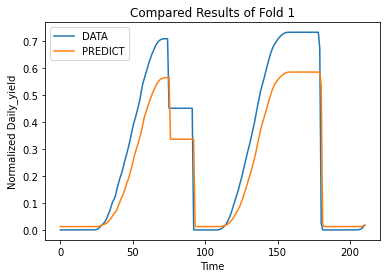

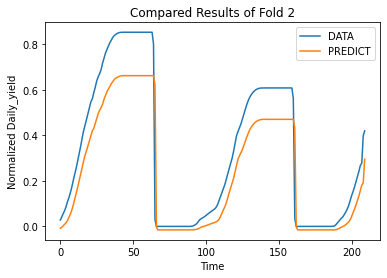

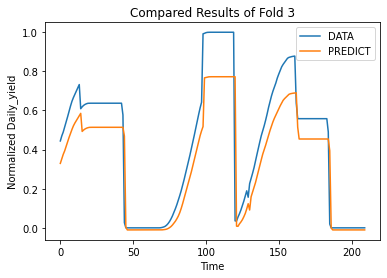

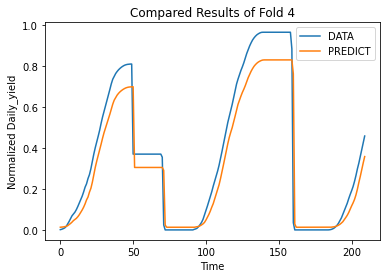

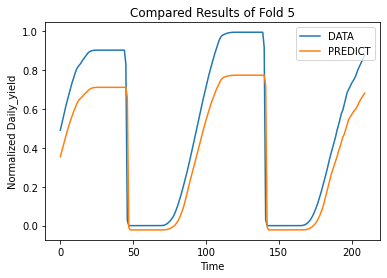

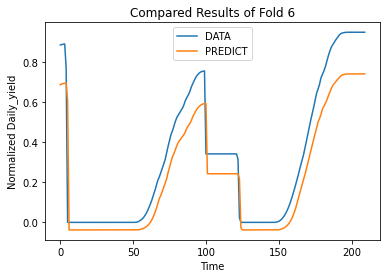

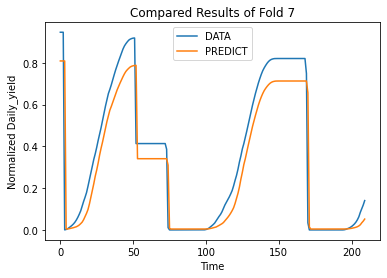

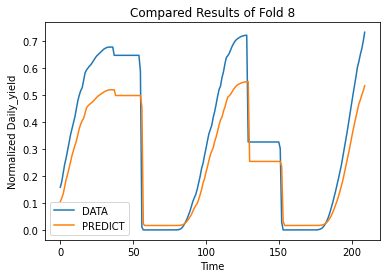

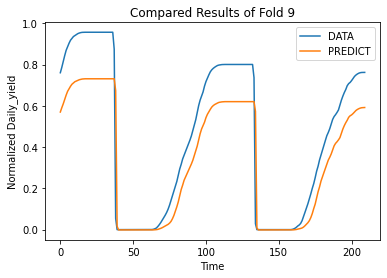

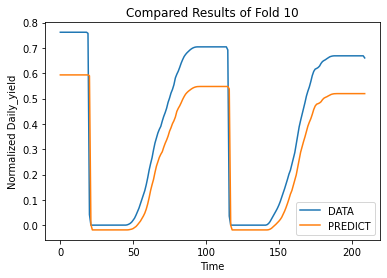

In [26]:
for test_index in range(k):
    test_loader = torch.utils.data.DataLoader(testdata[test_index], batch_size=batch_size)
    predict = prediction(test_loader,'model_fold_'+str(test_index+1)+'.pth')
    
    x_plot = range(len(kf_data['test_list'][test_index][1]))

    plt.plot(x_plot, kf_data['test_list'][test_index][1], label = "DATA")
    plt.plot(x_plot, predict, label = "PREDICT")

    plt.xlabel('Time')
    plt.ylabel('Normalized Daily_yield')
    plt.title('Compared Results of Fold ' + str(test_index+1))

    plt.legend()
    plt.show()

In [27]:
def n_day_prediction(data,model_path,n):
    result = []
    out = []
    model.load_state_dict(torch.load(model_path))
    if use_cuda:
        model.cuda() 
    model.eval()
    for i in range(n):
        output = model(data.float())
        out.append(list(np.squeeze(output.data.max(1, keepdim=True)[0]).cpu().numpy()))
        result = []
        for i in out:
            for j in i:
                result.append(j)
        data = result[:]
        data = torch.from_numpy(np.array(data))
    return result

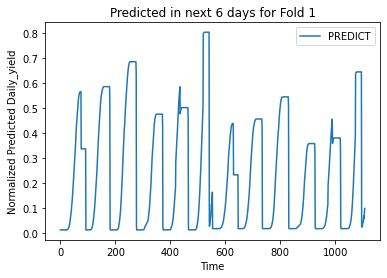

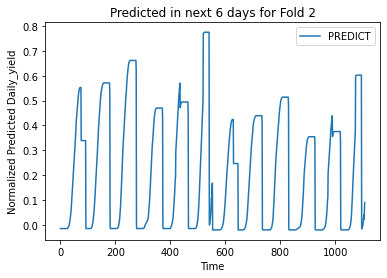

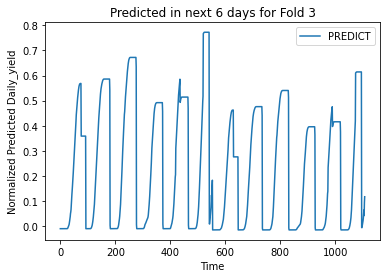

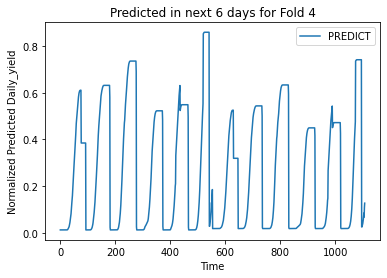

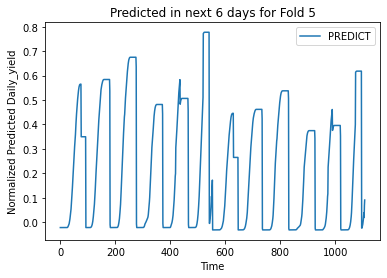

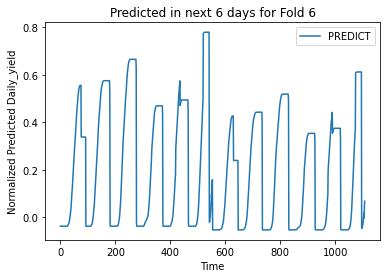

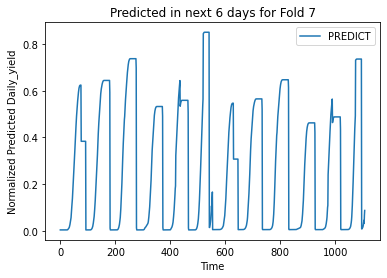

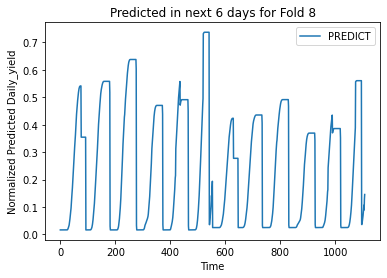

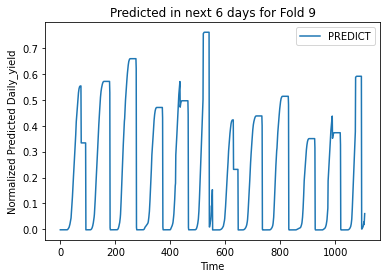

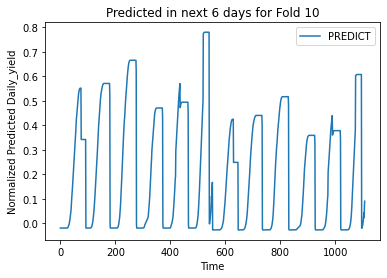

In [28]:
n = 2
first_point = torch.from_numpy(x_train[:277*n]) #3days data

for test_index in range(k):
    npred = n_day_prediction(first_point,'model_fold_'+str(test_index+1)+'.pth',n)
    x_plot = range(len(npred))

    plt.plot(x_plot, npred, label = "PREDICT")
    plt.xlabel('Time')
    
    plt.ylabel('Normalized Predicted Daily_yield')
    plt.title('Predicted in next ' + str(3*n) + ' days for Fold ' + str(test_index+1))

    plt.legend()
    plt.show()
    '''
    Total_yield = dialy_yield(prediction) + Total_yield(before)
    '''